In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
#import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
#from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
from osgeo import gdal

from matplotlib import pyplot as plt
#from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

from IPython.display import clear_output

seed = 56

In [10]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_BANDS = 8
images_path = 'Data/BuildingsDataSet/Images/'
masks_path = 'Data/BuildingsDataSet/Masks/'

In [11]:
def load_image(image):
    return gdal.Open(image, gdal.GA_ReadOnly)
    
def convert_to_array(dataset):
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
    return np.stack(bands, 2)

def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

In [ ]:
files = next(os.walk(images_path))[2]

all_images = []
all_masks = []
num_skipped = 0
for image_file in files:

    image_path = images_path + image_file
    image = load_image(image_path)
    image_data = convert_to_array(image)
    image_data[np.isnan(image_data)] = 0 # adiciona 0 onde é NaN
    image_data = normalize(image_data)

    mask_path = masks_path + image_file
    mask = load_image(mask_path)
    mask_data = convert_to_array(mask)
    mask_data[np.isnan(mask_data)] = 0 # adiciona 0 onde é NaN
    mask_data[mask_data>0] = 1
    mask_data[mask_data<=0] = 0
    
    # Pule qualquer imagem que esteja mais de 99% vazia.
    if np.any(mask_data):
        num_white_pixels = len(mask_data[mask_data==1])
        num_black_pixels = len(mask_data[mask_data==0])
        if num_black_pixels == 0: num_black_pixels = 1 # para evitar erro de dividir por 0

        if num_white_pixels/num_black_pixels < 0.01:
            num_skipped+=1
            continue
        
        all_images.append(image_data)
        all_masks.append(mask_data)
    
    #if len(all_images) > 2:
        #break

images = np.array(all_images)
masks = np.array(all_masks, dtype=int)
print('Total imagens: \n', len(all_images))
print('Images: \n', images.shape)
print('Masks: \n', masks.shape)
print("\n{} Images were skipped.".format(num_skipped))
print("\nUnique elements in the train mask:", np.unique(masks))

In [ ]:
plt.figure(figsize=(20,16))
x, y = 2,2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*2 + j*1
        #plt.imshow((images[pos][:,:,1:4]).astype(np.uint8))
        plt.imshow(np.clip(images[pos][:,:,[0,1,2]] / 5000, 0, 1))
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [270]:
#masks = np.expand_dims(masks, -1)

### Defining Custom Loss functions and accuracy Metric.

In [6]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

    return iou

In [7]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Splitting data

In [13]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(108, 256, 256, 8)
(108, 256, 256, 1)
TEST SET
(28, 256, 256, 8)
(28, 256, 256, 1)


### Defining Our Model

In [8]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [ ]:
"""inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
#s = Lambda(lambda x: x) (inputs)
#s = Lambda(lambda x: x / 255) (inputs)

kernel_size = (3, 3)
activation = 'relu'

conv1 = Conv2D(16, kernel_size, activation=activation, padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, kernel_size, activation=activation, padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, kernel_size, activation=activation, padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, kernel_size, activation=activation, padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, kernel_size, activation=activation, padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, kernel_size, activation=activation, padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, kernel_size, activation=activation, padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, kernel_size, activation=activation, padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, kernel_size, activation=activation, padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, kernel_size, activation=activation, padding='same') (conv5)
conv5 = BatchNormalization() (conv5)

upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, kernel_size, activation=activation, padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, kernel_size, activation=activation, padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, kernel_size, activation=activation, padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, kernel_size, activation=activation, padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, kernel_size, activation=activation, padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, kernel_size, activation=activation, padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, kernel_size, activation=activation, padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, kernel_size, activation=activation, padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

In [ ]:
"""inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_BANDS))
#s = Lambda(lambda x: x) (inputs)
#s = Lambda(lambda x: x / 255) (inputs)

kernel_size = (3, 3)
activation = 'relu'

conv1 = Conv2D(32, kernel_size, activation=activation, padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(32, kernel_size, activation=activation, padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(64, kernel_size, activation=activation, padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(64, kernel_size, activation=activation, padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(128, kernel_size, activation=activation, padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(128, kernel_size, activation=activation, padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(256, kernel_size, activation=activation, padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(256, kernel_size, activation=activation, padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
#pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

"""conv5 = Conv2D(256, kernel_size, activation=activation, padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, kernel_size, activation=activation, padding='same') (conv5)
conv5 = BatchNormalization() (conv5)
"""

upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv4)
upsample6 = concatenate([upsample6, conv3])
conv6 = Conv2D(128, kernel_size, activation=activation, padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, kernel_size, activation=activation, padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv2])
conv7 = Conv2D(64, kernel_size, activation=activation, padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, kernel_size, activation=activation, padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv1])
conv8 = Conv2D(32, kernel_size, activation=activation, padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, kernel_size, activation=activation, padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

"""upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, kernel_size, activation=activation, padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, kernel_size, activation=activation, padding='same') (conv9)
conv9 = BatchNormalization() (conv9)
"""

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv8)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

In [312]:
import import_ipynb
import unet_lstm_model as M

In [ ]:
import importlib
importlib.reload(M)

In [ ]:
model = M.BCDU_net_D3(input_size = (IMAGE_WIDTH, IMAGE_HEIGHT, NUM_BANDS))
model.summary()

### HYPER_PARAMETERS

In [340]:
EPOCHS = 50
#LEARNING_RATE = 0.0001
LEARNING_RATE = 0.0001
#BATCH_SIZE = 16
BATCH_SIZE = 16

### Initializing Callbacks

In [315]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
tbc=TensorBoardColab()

In [327]:
model_path = "Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4)

### Compiling the model

In [317]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        #print(display_list[i][:,:,[1,2,1]])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

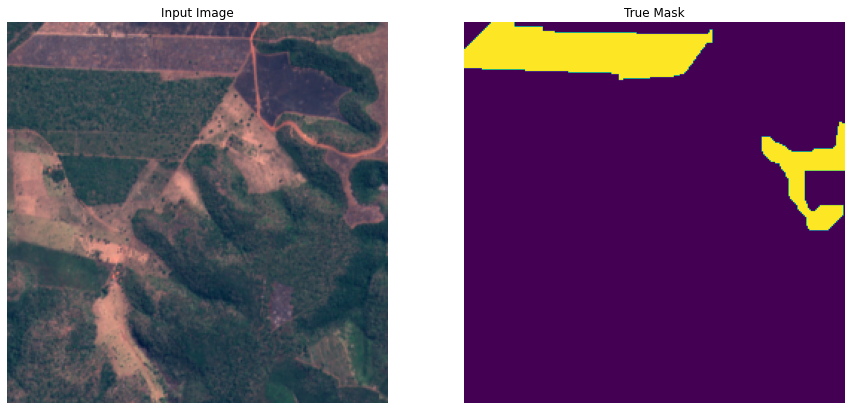

In [318]:
i = 1
sample_image, sample_mask = train_images[i], train_masks[i]
display([sample_image[:,:,[2,1,0]], sample_mask])

In [252]:
"""def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [325]:
def show_predictions(dataset=None, num=1):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image[:,:,[2,1,0]], sample_mask, pred_mask[0]])

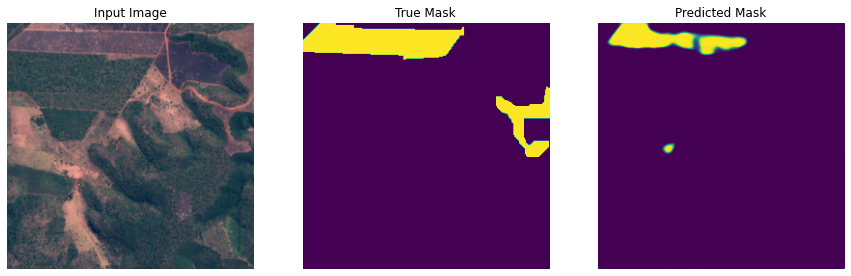

In [341]:
show_predictions()

In [321]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [322]:
opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef, 'accuracy'])

In [239]:
"""from keras.optimizers import Adam
#model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

class_weights = [0.2, 0.3, 0.1, 0.1, 0.3]

def weighted_binary_crossentropy(y_true, y_pred):
    class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
    return K.sum(class_loglosses * K.constant(class_weights))

model.compile(optimizer=Adam(lr = 1e-4), loss=weighted_binary_crossentropy, metrics=["accuracy"])

In [323]:
#mcp_save = ModelCheckpoint('weights', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

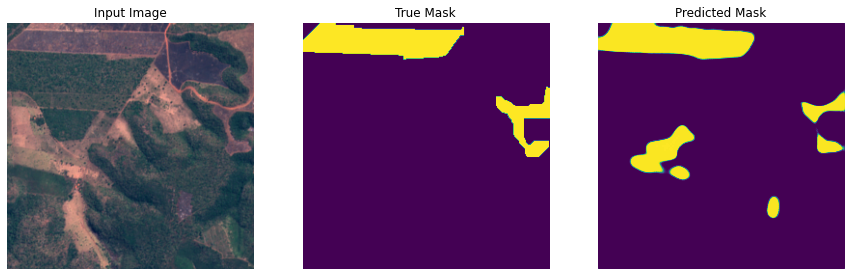


Sample Prediction after epoch 50

7/7 [==============================] - 88s 13s/step - loss: 0.2694 - iou_coef: 0.4755 - accuracy: 0.9725 - val_loss: 0.1648 - val_iou_coef: 0.4115 - val_accuracy: 0.9756


In [342]:
history = model.fit(train_images,
                    train_masks/1,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[checkpointer, DisplayCallback()]
                    #callbacks = [DisplayCallback()]
                    #callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                  )

In [343]:
model.save("./Models/road_mapper_final.h5")

## Testing our Model

### On Test Images

In [8]:
model = load_model("./Models/road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [44]:
model.evaluate(test_images, test_masks)

1/1 [==============================] - 0s 1ms/step - loss: 0.6238 - iou_coef: 0.2516 - accuracy: 0.9579


[0.6237865686416626, 0.25157052278518677, 0.9578620791435242]

In [14]:
predictions = model.predict(test_images, verbose=1)

1/1 [==============================] - 0s 3ms/step


In [189]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

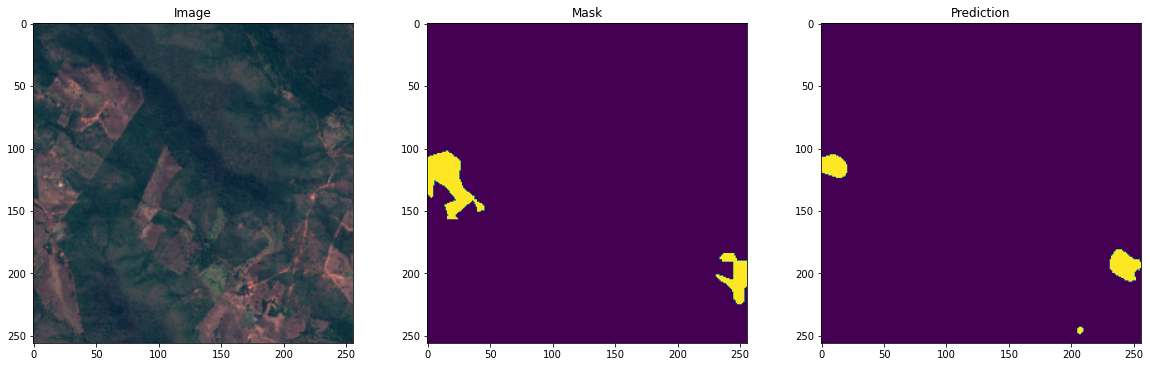

In [18]:
i = 3
p = predictions[i]
#p = p*255
#p[p>0.5] = 1
#p[p<=0.5] = 0
p = np.where(p > 0.5, 1, 0)

f = plt.figure(figsize=(20,20))

f.add_subplot(3, 3, 1)
# 2 = B4, 1 = B3, 0 = B2
#imshow(test_images[i][:,:,[2,1,0]])
#plt.imshow(test_images[i][:,:,[2,1,0]])
plt.imshow(tf.keras.preprocessing.image.array_to_img(test_images[i][:,:,[2,1,0]]))
plt.title('Image')

f.add_subplot(3, 3, 2)
plt.imshow(test_masks[i])
plt.title('Mask')

f.add_subplot(3, 3, 3)
plt.imshow(p)
plt.title('Prediction')

# colorido
#f.subplot(3, 3, 3)
#plt.imshow(p)
#plt.title('Prediction')
        
plt.show()

In [ ]:
#ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
    ix = random.randint(0, len(predictions))

    f.add_subplot(num_samples, 4, i)
    imshow(test_images[ix][:,:])
    plt.title("Image")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+1)
    imshow(np.squeeze(test_masks[ix][:,:,0]))
    plt.title("Groud Truth {}".format(ix))
    plt.axis('off')

    #pred = predictions[ix]*255
    f.add_subplot(num_samples, 4, i+2)
    imshow(np.squeeze(predictions[ix][:,:,0]))
    plt.title("Prediction")
    plt.axis('off')

    f.add_subplot(num_samples, 4, i+3)
    imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
    plt.title("thresholded at {}".format(thresh_val))
    plt.axis('off')

plt.show()